### Code Hist.

 - CODE  
    &ensp; : Model - KIER Method 02(Clustering)

  - DATE      &ensp; 2023-03-05 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) Dataset : KIER / KMA_ASOS    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Model : LightGBM  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
os.path.dirname(os.path.abspath('__file__'))
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import math
import random

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split

# CLustering 알고리즘의 성능 평가 측도
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
# !pip install catboost

## LGBM
from catboost import Pool, CatBoostRegressor

# !pip install lightgbm

## LGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

## LSTM
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
## Import_Local
from Src_Dev_Common import DEV_Common_Data_Datetime as com_date
from Src_Dev_Common import DEV_KASI_Holiday as com_Holi
from Src_Dev_Common import DEV_Common_Data_Analysis as com_Analysis
from Src_Dev_Common import DEV_Common_Data_Preprocessing as com_Prep
from Src_Dev_Common import DEV_Common_Data_Visualization as com_Visual
from Src_Dev_Common import DEV_KMA_Weather_ASOS as com_ASOS
from Src_Dev_Common import DEV_KDHC_Usage as com_KDHC
from Src_Dev_Common import DEV_KIER_Usage as com_KIER

### 01-01-02. Config (Directory, Params)

In [5]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [6]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-03-28 23:52:35.180840
2024 / 3 / 28
23 : 52


In [7]:
## Dict_Domain
dict_domain = {0:"ELEC", 1:"HEAT", 2:"WATER", 3:"HOT_HEAT", 4:"HOT_FLOW", 99:"GAS"} ## GAS는 사용하지 않음.
int_domain = 0
str_domain = str(dict_domain[int_domain])

dict_col_accu = {0 : "ACTUAL_ACCU_EFF" ## ELEC
                 , 1 : "ACCU_HEAT" ## HEAT
                 , 2 : "ACCU_FLOW" ## WATER
                 , 3 : "ACCU_HEAT" ## HOT 열량
                 , 4 : "ACCU_FLOW" ## HOT 유량
                 , 99 : "ACCU_FLOW" ## GAS
                 }
str_col_accu = str(str_domain + "_" + str(dict_col_accu[int_domain]))

dict_col_inst = {0 : "INST_EFF" ## ELEC_ACCU/INST_EFF
                , 1 : "INST_HEAT" ## HEAT_ACCU/INST_HEAT
                , 2 : "INST_FLOW" ## WATER_ACCU/INST_FLOW
                , 3 : "INST_HEAT" ## HOT_ACCU/INST_HEAT
                , 4 : "INST_FLOW" ## HOT_ACCU/INST_FLOW
                , 99 : "INST_FLOW" ## GAS_ACCU/INST_FLOW
                } 
str_col_inst = str(str_domain + "_" + str(dict_col_inst[int_domain]))

## Directory Root
str_dirData = "../data/data_Energy_KIER/"
str_dir_raw = '../data/data_Energy_KIER/KIER_0_Raw/'
str_dirName_bld = '../data/data_Energy_KIER/KIER_1_BLD/'
str_dirName_f = '../data/data_Energy_KIER/KIER_2_F_' + str_domain + '/'
str_dirName_h = '../data/data_Energy_KIER/KIER_3_H_' + str_domain + '/'

## File
str_fileRaw = str('KIER_RAW_' + str_domain + '_2023-11-12.csv')
str_fileRaw_hList = str('KIER_hList_' + str_domain + '.csv')

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'Data_Population_SJ_2014_2018_1st_Interpolated.csv', 'Data_Population_SJ_2014_2018_D_1st_Interpolated.csv', 'Data_Population_SJ_2014_2018_H_1st_Interpolated.csv', 'DATE_1M_2023-10-20.csv', 'ENV_SENSOR_HST_202309251452.csv', 'F1_MAIN_POWER_HST_202309251503.csv', 'F1_SUB_POWER_HST_202309251510.csv', 'HEATPUMP_HST_202309251520.csv', 'KIER_0_Raw', 'KIER_1_BLD', 'KIER_2_F_ELEC', 'KIER_2_F_GAS', 'KIER_2_F_HEAT', 'KIER_2_F_HOT', 'KIER_2_F_WATER', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_DATA_OLD', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', 'LIGHT_HST_202309251523.csv', 'MACHINE_ROOM_HEAT_HST_202309251534.csv', 'MACHINE_ROOM_POWER_APT_HST_20221205_202309251617.csv', 'MACHINE_ROOM_POWER_APT_HS

## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage (Intergrated)

In [8]:
## KMA_ASOS Data
str_dir_kmaAsos = "../data/data_KMA_ASOS/"

## Interpolate / Filled ASOS Data
str_file = 'ASOS_119_2010-2024_HR_INTP.csv'
Data_ASOS = pd.read_csv(str_dir_kmaAsos + str_file
                        , index_col = 0)
Data_ASOS['METER_DATE'] = pd.to_datetime(Data_ASOS['METER_DATE'])
Data_ASOS

,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,temp_outdoor,temp_dew_point,temp_ground,...,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,None,METER_DATE
0,Friday,2010,1,1,0,0,4,-10.3000000000,-17.6000000000,-5.8000000000,...,1.5000000000,1019.7000000000,1024.3000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,0,2010-01-01 00:00:00
1,Friday,2010,1,1,1,0,4,-10.4000000000,-17.9000000000,-5.7000000000,...,1.5000000000,1019.5000000000,1024.1000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,2010-01-01 01:00:00
2,Friday,2010,1,1,2,0,4,-10.6000000000,-17.6000000000,-5.9000000000,...,1.5000000000,1019.7000000000,1024.3000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,2010-01-01 02:00:00
3,Friday,2010,1,1,3,0,4,-11.0000000000,-18.0000000000,-5.9000000000,...,1.5000000000,1019.7000000000,1024.3000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,0,2010-01-01 03:00:00
4,Friday,2010,1,1,4,0,4,-11.6000000000,-18.2000000000,-6.0000000000,...,1.5000000000,1019.4000000000,1024.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124459,Wednesday,2024,3,13,19,0,2,6.8000000000,-1.6000000000,4.9000000000,...,5.4000000000,1016.2000000000,1021.1000000000,0.1000000000,0.0600000000,0.0000000000,0.0000000000,2085.0000000000,0,2024-03-13 19:00:00
124460,Wednesday,2024,3,13,20,0,2,6.2000000000,-2.6000000000,3.3000000000,...,5.0000000000,1016.3000000000,1021.2000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2180.0000000000,0,2024-03-13 20:00:00
124461,Wednesday,2024,3,13,21,0,2,5.2000000000,-2.1000000000,2.0000000000,...,5.2000000000,1016.7000000000,1021.7000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1978.0000000000,0,2024-03-13 21:00:00
124462,Wednesday,2024,3,13,22,0,2,4.6000000000,-1.0000000000,1.4000000000,...,5.7000000000,1016.8000000000,1021.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1670.0000000000,0,2024-03-13 22:00:00


In [37]:
## Cluster 기준 Interval
list_interval = ['10MIN', '1H', '1D', '1W', '1M']
str_interval = list_interval[2]
## Cluster 수
K = 3
str_file_clustering = 'KIER_' + str(str_domain) + '_Labeled_' + str_interval + '_K' + str(K) + '.csv'
df_kier_h_cluster = pd.read_csv(str_dirName_h + str_file_clustering
                                , index_col = 0).rename(columns = {'index' : 'h_index'})[['h_index', 'target_' + str_domain]]
print(str_interval)
print(df_kier_h_cluster['target_' + str_domain].drop_duplicates())
df_kier_h_cluster

1D
0    2
2    1
5    0
Name: target_ELEC, dtype: int64


,h_index,target_ELEC
0,ELEC_INST_EFF_561-1-1,2
1,ELEC_INST_EFF_561-1-2,2
2,ELEC_INST_EFF_561-1-3,1
3,ELEC_INST_EFF_561-1-4,2
4,ELEC_INST_EFF_561-2-1,1
...,...,...
343,ELEC_INST_EFF_563-23-2,2
344,ELEC_INST_EFF_563-23-3,1
345,ELEC_INST_EFF_563-23-4,1
346,ELEC_INST_EFF_563-24-1,1


In [38]:
list_kier_h_all = df_kier_h_cluster['h_index']
print(len(list_kier_h_all))
list_kier_h_c0 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 0]['h_index']
print(len(list_kier_h_c0))
list_kier_h_c1 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 1]['h_index']
print(len(list_kier_h_c1))
list_kier_h_c2 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 2]['h_index']
print(len(list_kier_h_c2))

348
80
188
80


In [39]:
## 사용량 Data Load
## 1시간 단위
str_file = 'KIER_' + str_domain + '_INST_03-02_1H.csv'
df_raw = pd.read_csv(str_dirName_h + str_file
                     , index_col = 0)
df_raw = df_raw.drop(columns = ['METER_DATE'])
df_raw

,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,ELEC_INST_EFF_561-3-2,...,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2
0,0.8600000000,1.2500000000,0.1700000000,1.0645217391,0.8600000000,0.2500000000,0.6000000000,0.4800000000,0.8100000000,0.3200000000,...,0.6000000000,0.6100000000,0.1900000000,0.2200000000,0.2200000000,0.3600000000,0.2600000000,0.2100000000,0.1600000000,0.4400000000
1,0.7280647787,1.1200000000,0.1800000000,0.9600000000,0.4500000000,0.2600000000,0.6000000000,0.4600000000,0.7100000000,0.4000000000,...,0.2373076923,0.4600000000,0.1600000000,0.2400000000,0.3100000000,0.4100000000,0.2500000000,0.2000000000,0.1400000000,0.3860498534
2,0.5020212513,0.9900000000,0.1900000000,0.8900000000,0.5800000000,0.2400000000,0.6300000000,0.4500000000,0.7000000000,0.2900000000,...,0.2100000000,0.2700000000,0.1600000000,0.2700000000,0.2500000000,0.3400000000,0.2600000000,0.2000000000,0.1300000000,0.2500000000
3,0.3300000000,1.0300000000,0.2000000000,1.0600000000,0.2700000000,0.1800000000,0.1400000000,0.2700000000,0.6100000000,0.4000000000,...,0.2000000000,0.2500000000,0.1400000000,0.2400000000,0.2100000000,0.3400000000,0.2600000000,0.1900000000,0.1400000000,0.2200000000
4,0.2600000000,1.0000000000,0.2700000000,0.8700000000,0.6200000000,0.1700000000,0.1300000000,0.2300000000,0.5700000000,0.2800000000,...,0.2100000000,0.2800000000,0.1300000000,0.3200000000,0.1900000000,0.4600000000,0.2800000000,0.1800000000,0.1800000000,0.3000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14160,0.4900000000,0.3200000000,0.2200000000,0.2800000000,0.6100000000,0.1300000000,0.1000000000,0.4900000000,0.2300000000,0.2000000000,...,0.1100000000,0.3200000000,0.1800000000,0.1600000000,0.1400000000,0.6800000000,0.2600000000,0.2000000000,0.1700000000,0.2100000000
14161,0.4600000000,0.2500000000,0.2900000000,0.1700000000,0.3900000000,0.1900000000,0.1000000000,0.3000000000,0.1900000000,0.2400000000,...,0.1000000000,0.3300000000,0.1800000000,0.1700000000,0.1500000000,0.5900000000,0.2300000000,0.1900000000,0.1500000000,0.2100000000
14162,0.5100000000,0.2100000000,0.1900000000,0.2300000000,0.3300000000,0.1500000000,0.0900000000,0.1900000000,0.1700000000,0.2500000000,...,0.0700000000,0.3100000000,0.1800000000,0.1500000000,0.1500000000,0.6500000000,0.2300000000,0.2000000000,0.1600000000,0.1900000000
14163,0.0900000000,0.0400000000,0.0200000000,0.0400000000,0.0500000000,0.0200000000,0.0200000000,0.0200000000,0.0500000000,0.0400000000,...,0.0100000000,0.0400000000,0.0200000000,0.0300000000,0.0200000000,0.1100000000,0.0500000000,0.0300000000,0.0200000000,0.0400000000


In [40]:
## 전체 사용량
df_kier_h_all = df_raw.copy()
## 0으로 표기되는 마지막행 제거
df_kier_h_all = df_kier_h_all[:-1]
print(df_kier_h_all.shape)

## Cluster별 사용량
## ■ C00
df_kier_h_c0 = df_raw.copy()[list_kier_h_c0]
df_kier_h_c0 = df_kier_h_c0[:-1]
print(df_kier_h_c0.shape)

## ■ C01
df_kier_h_c1 = df_raw.copy()[list_kier_h_c1]
df_kier_h_c1 = df_kier_h_c1[:-1]
print(df_kier_h_c1.shape)

## ■ C02
df_kier_h_c2 = df_raw.copy()[list_kier_h_c2]
df_kier_h_c2 = df_kier_h_c2[:-1]
print(df_kier_h_c2.shape)

(14164, 348)
(14164, 80)
(14164, 188)
(14164, 80)


In [41]:
df_kier_h_c0

,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-3-2,ELEC_INST_EFF_561-5-2,ELEC_INST_EFF_561-6-3,ELEC_INST_EFF_561-8-2,ELEC_INST_EFF_561-8-3,ELEC_INST_EFF_561-12-2,ELEC_INST_EFF_561-12-4,ELEC_INST_EFF_561-13-2,ELEC_INST_EFF_561-14-4,...,ELEC_INST_EFF_563-17-6,ELEC_INST_EFF_563-18-1,ELEC_INST_EFF_563-18-2,ELEC_INST_EFF_563-18-6,ELEC_INST_EFF_563-19-1,ELEC_INST_EFF_563-19-2,ELEC_INST_EFF_563-19-3,ELEC_INST_EFF_563-20-1,ELEC_INST_EFF_563-20-2,ELEC_INST_EFF_563-21-2
0,0.2500000000,0.3200000000,0.2400000000,0.1800000000,0.1500000000,0.2800000000,0.2600000000,0.2600000000,0.2500000000,0.2100000000,...,0.1300000000,0.1600000000,0.3100000000,0.4200000000,0.0000000000,0.3100000000,0.0525000000,0.1600000000,0.2100000000,0.3100000000
1,0.2600000000,0.4000000000,0.1700000000,0.1600000000,0.2000000000,0.2300000000,0.2400000000,0.2800000000,0.2134764638,0.1700000000,...,0.1300000000,0.1600000000,0.3000000000,0.2130000000,0.0100000000,0.2200000000,0.0611250000,0.1500000000,0.1900000000,0.1800000000
2,0.2400000000,0.2900000000,0.1300000000,0.1800000000,0.2300000000,0.1400000000,0.2200000000,0.2100000000,0.1700000000,0.1800000000,...,0.1300000000,0.1400000000,0.2400000000,0.1715588235,0.0000000000,0.2000000000,0.1397000475,0.1900000000,0.1900000000,0.1500000000
3,0.1800000000,0.4000000000,0.1400000000,0.1800000000,0.2000000000,0.4000000000,0.2200000000,0.2500000000,0.1753197674,0.1500000000,...,0.1700000000,0.2300000000,0.2500000000,0.1800000000,0.0895272602,0.1900000000,0.0525000000,0.2300000000,0.1700000000,0.1700000000
4,0.1700000000,0.2800000000,0.1300000000,0.1600000000,0.1500000000,0.3400000000,0.2100000000,0.2100000000,0.1733430233,0.1600000000,...,0.1200000000,0.3500000000,0.2700000000,0.1200000000,0.0100000000,0.2000000000,0.0525000000,0.1700000000,0.1700000000,0.2500000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14159,0.1300000000,0.2400000000,0.3000000000,0.3400000000,0.4000000000,0.1400000000,0.3700000000,1.4890625000,0.0200000000,0.5700000000,...,0.2100000000,0.1200000000,0.3600000000,0.3300000000,0.5800000000,0.8000000000,0.0600000000,0.0900000000,0.4000000000,0.2100000000
14160,0.1300000000,0.2000000000,0.2400000000,0.2300000000,0.3200000000,0.1400000000,0.1700000000,0.3700000000,0.0100000000,0.4600000000,...,0.1800000000,0.0800000000,0.3700000000,0.2500000000,0.3900000000,0.7100000000,0.0600000000,0.0900000000,0.1800000000,0.2000000000
14161,0.1900000000,0.2400000000,0.1800000000,0.1200000000,0.2200000000,0.1400000000,0.1800000000,0.2600000000,0.0100000000,0.3600000000,...,0.1700000000,0.0800000000,0.3700000000,0.2000000000,0.3800000000,0.6500000000,0.0600000000,0.0800000000,0.1000000000,0.1600000000
14162,0.1500000000,0.2500000000,0.1700000000,0.1200000000,0.1900000000,0.1700000000,0.1800000000,0.2100000000,0.0200000000,0.3200000000,...,0.1000000000,0.1000000000,0.3600000000,0.1800000000,0.3700000000,0.6100000000,0.0600000000,0.0900000000,0.1000000000,0.1000000000


## 01-06. Data Split (Train/Test Setting)

In [54]:
## 모든 세대
# df_raw = df_kier_h_all
# str_col_tar = str_domain + '_INST_SUM_ALL'
## C1 세대
df_raw = df_kier_h_c0
str_col_tar = str_domain + '_INST_SUM_C0'
## C2 세대
# df_raw = df_kier_h_c1
# str_col_tar = str_domain + '_INST_SUM_C1'
## C3 세대
# df_raw = df_kier_h_c2
# str_col_tar = str_domain + '_INST_SUM_C2'

df_raw.shape

(14164, 80)

In [55]:
## 군집 내 모든 값의 분산
df_concatnated = pd.DataFrame()
int_cnt = 0
for tar_col in df_raw.columns:
    # print(tar_col)
    df_temp = df_raw[[tar_col]].copy()
    df_temp = df_temp.rename(columns = {tar_col : "Usage"})

    if int_cnt == 0:
        df_concatnated = df_temp.copy()
    else:
        df_concatnated = pd.concat([df_concatnated, df_temp])

    int_cnt = int_cnt + 1

# print("Var : ", np.var(df_concatnated["Usage"]))
print("Max : ", np.max(df_concatnated["Usage"]))
print("75 : ", np.percentile(df_concatnated["Usage"], 75))
# print("Mean : ", np.mean(df_concatnated["Usage"])) ## 이미 아래 기술통계 항목에 평균이 포함되어있음
print("Med : ", np.median(df_concatnated["Usage"]))
print("25 : ", np.percentile(df_concatnated["Usage"], 25))
print("Min : ", np.min(df_concatnated["Usage"]))


print(stats.describe(df_concatnated))
print("Std : ", np.std(df_concatnated["Usage"]))
print("CV : ", np.std(df_concatnated["Usage"]) / np.mean(df_concatnated["Usage"]))

Max :  4.113439941406568
75 :  0.349999999999909
Med :  0.2200000000002546
25 :  0.1400000000003274
Min :  0.0
DescribeResult(nobs=1133120, minmax=(array([0.]), array([4.11343994])), mean=array([0.27863894]), variance=array([0.04893392]), skewness=array([2.88481085]), kurtosis=array([15.33429953]))
Std :  0.22121003026877137
CV :  0.7938948839874627


In [56]:
df_raw.isna().sum()

ELEC_INST_EFF_561-2-2     0
ELEC_INST_EFF_561-3-2     0
ELEC_INST_EFF_561-5-2     0
ELEC_INST_EFF_561-6-3     0
ELEC_INST_EFF_561-8-2     0
                         ..
ELEC_INST_EFF_563-19-2    0
ELEC_INST_EFF_563-19-3    0
ELEC_INST_EFF_563-20-1    0
ELEC_INST_EFF_563-20-2    0
ELEC_INST_EFF_563-21-2    0
Length: 80, dtype: int64

In [57]:
from sklearn.manifold import TSNE

## 표현할 데이터 차원
n_components = 2

## t-sne Model
model = TSNE(n_components = n_components)

## 학습 결과
res_tsne = model.fit_transform(df_raw)
print(res_tsne)

[[-43.3798    61.75011 ]
 [-45.149418  58.0079  ]
 [-46.0649    55.628067]
 ...
 [ 17.45476  -74.75424 ]
 [ 17.422264 -74.82878 ]
 [-53.130928  32.048496]]


In [58]:
print(res_tsne[0])

[-43.3798   61.75011]


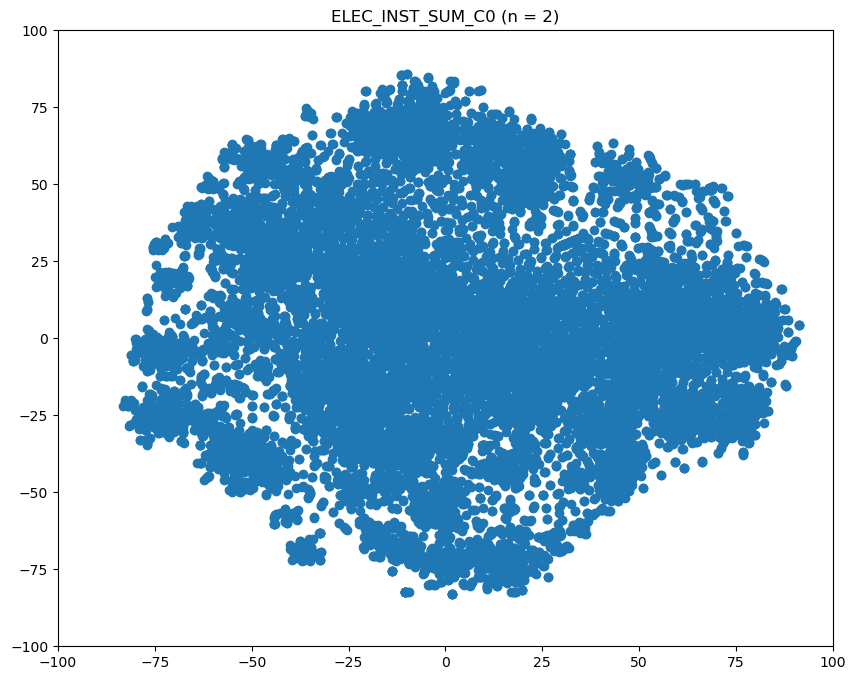

In [59]:
if n_components == 2:
    ## 2차원
    plt.scatter(res_tsne[:, 0], res_tsne[:, 1])
elif n_components == 3:
    ## 3차원
    plt.scatter(res_tsne[:, 0], res_tsne[:, 1], res_tsne[:, 2])

plt.title(str(str_col_tar + " (n = " + str(n_components) + ")"))

## 비교를 위한 범위 지정
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.show()